# Set up EDB for Serdes channel S-parameter extraction

## Import the required packages

In [1]:
import json

In [2]:
import os
import tempfile

from ansys.aedt.core import Hfss3dLayout
from ansys.aedt.core.downloads import download_file

from pyedb import Edb

AEDT_VERSION = "2024.2"
NG_MODE = False


Download the example PCB data.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
file_edb = download_file(source="edb/ANSYS-HSD_V1.aedb", destination=temp_folder.name)
download_file(source="touchstone", name="GRM32_DC0V_25degC_series.s2p", destination=os.path.split(file_edb)[0])

'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmp415zozi8.ansys\\edb\\touchstone\\GRM32_DC0V_25degC_series.s2p'

## Load example layout

In [4]:
edbapp = Edb(file_edb, edbversion=AEDT_VERSION)

PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.34.3


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database ANSYS-HSD_V1.aedb Opened in 2024.2


PyAEDT INFO: Cell main Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


## Create config file

In [5]:
cfg_general = {"anti_pads_always_on": True, "suppress_pads": True}

Define dielectric materials, stackup and surface roughness model.

In [6]:
cfg_stackup = {
    "materials": [
        {"name": "copper", "permittivity": 1, "conductivity": 58000000.0},
        {"name": "megtron4", "permittivity": 3.77, "dielectric_loss_tangent": 0.005},
        {"name": "solder_resist", "permittivity": 3.0, "dielectric_loss_tangent": 0.035},
    ],
    "layers": [
        {
            "name": "Top",
            "type": "signal",
            "material": "copper",
            "fill_material": "solder_resist",
            "thickness": "0.035mm",
            "roughness": {
                "top": {"model": "huray", "nodule_radius": "0.5um", "surface_ratio": "5"},
                "bottom": {"model": "huray", "nodule_radius": "0.5um", "surface_ratio": "5"},
                "side": {"model": "huray", "nodule_radius": "0.5um", "surface_ratio": "5"},
                "enabled": True,
            },
        },
        {"name": "DE1", "type": "dielectric", "material": "megtron4", "fill_material": "", "thickness": "0.1mm"},
        {"name": "Inner1", "type": "signal", "material": "copper", "fill_material": "megtron4", "thickness": "0.017mm"},
        {"name": "DE2", "type": "dielectric", "material": "megtron4", "fill_material": "", "thickness": "0.088mm"},
        {"name": "Inner2", "type": "signal", "material": "copper", "fill_material": "megtron4", "thickness": "0.017mm"},
        {"name": "DE3", "type": "dielectric", "material": "megtron4", "fill_material": "", "thickness": "0.1mm"},
        {"name": "Inner3", "type": "signal", "material": "copper", "fill_material": "megtron4", "thickness": "0.017mm"},
        {"name": "Megtron4-1mm", "type": "dielectric", "material": "megtron4", "fill_material": "", "thickness": 0.001},
        {"name": "Inner4", "type": "signal", "material": "copper", "fill_material": "megtron4", "thickness": "0.017mm"},
        {"name": "DE5", "type": "dielectric", "material": "megtron4", "fill_material": "", "thickness": "0.1mm"},
        {"name": "Inner5", "type": "signal", "material": "copper", "fill_material": "megtron4", "thickness": "0.017mm"},
        {"name": "DE6", "type": "dielectric", "material": "megtron4", "fill_material": "", "thickness": "0.088mm"},
        {"name": "Inner6", "type": "signal", "material": "copper", "fill_material": "megtron4", "thickness": "0.017mm"},
        {"name": "DE7", "type": "dielectric", "material": "megtron4", "fill_material": "", "thickness": "0.1mm"},
        {
            "name": "Bottom",
            "type": "signal",
            "material": "copper",
            "fill_material": "solder_resist",
            "thickness": "0.035mm",
        },
    ],
}

Define Component with solderballs.

In [7]:
cfg_components = [
    {
        "reference_designator": "U1",
        "part_type": "io",
        "solder_ball_properties": {"shape": "cylinder", "diameter": "300um", "height": "300um"},
        "port_properties": {
            "reference_offset": "0",
            "reference_size_auto": True,
            "reference_size_x": 0,
            "reference_size_y": 0,
        },
    }
]

Edit via padstack definition. Add backdrilling.

In [8]:
cfg_padstacks = {
    "definitions": [
        {
            "name": "v40h15-2",
            "material": "copper",
            "hole_range": "upper_pad_to_lower_pad",
            "hole_parameters": {"shape": "circle", "diameter": "0.2mm"},
        },
        {
            "name": "v35h15-1",
            "material": "copper",
            "hole_range": "upper_pad_to_lower_pad",
            "hole_parameters": {"shape": "circle", "diameter": "0.25mm"},
        },
    ],
    "instances": [
        {
            "name": "Via313",
            "backdrill_parameters": {
                "from_bottom": {"drill_to_layer": "Inner3", "diameter": "1mm", "stub_length": "0.2mm"}
            },
        },
        {
            "name": "Via314",
            "backdrill_parameters": {
                "from_bottom": {"drill_to_layer": "Inner3", "diameter": "1mm", "stub_length": "0.2mm"}
            },
        },
    ],
}

Define ports.

In [9]:
cfg_ports = [
    {
        "name": "port_1",
        "reference_designator": "U1",
        "type": "coax",
        "positive_terminal": {"net": "PCIe_Gen4_TX2_CAP_P"},
    },
    {
        "name": "port_2",
        "reference_designator": "U1",
        "type": "coax",
        "positive_terminal": {"net": "PCIe_Gen4_TX2_CAP_N"},
    },
    {
        "name": "port_3",
        "reference_designator": "X1",
        "type": "circuit",
        "positive_terminal": {"pin": "B8"},
        "negative_terminal": {"pin": "B7"},
    },
    {
        "name": "port_4",
        "reference_designator": "X1",
        "type": "circuit",
        "positive_terminal": {"pin": "B9"},
        "negative_terminal": {"pin": "B10"},
    },
]

Define S-parameter assignment

In [10]:
cfg_s_parameters = [
    {
        "name": "cap_10nf",
        "file_path": "$PROJECTDIR\\touchstone\\GRM32_DC0V_25degC_series.s2p",
        "component_definition": "CAPC1005X55X25LL05T10",
        "components": ["C375", "C376"],
        "reference_net": "GND",
    }
]

Define SIwave setup.

In [11]:
cfg_setups = [
    {
        "name": "siwave_setup",
        "type": "siwave_ac",
        "si_slider_position": 1,
        "freq_sweep": [
            {
                "name": "Sweep1",
                "type": "interpolation",
                "frequencies": [
                    {"distribution": "linear_scale", "start": "50MHz", "stop": "20GHz", "increment": "50MHz"}
                ],
            }
        ],
    }
]

Define cutout.

In [12]:
cfg_operations = {
    "cutout": {
        "signal_list": ["PCIe_Gen4_TX2_CAP_P", "PCIe_Gen4_TX2_CAP_N", "PCIe_Gen4_TX2_P", "PCIe_Gen4_TX2_N"],
        "reference_list": ["GND"],
        "custom_extent": [
            [0.014, 0.055],
            [0.03674271504652968, 0.05493094625752912],
            [0.07, 0.039],
            [0.07, 0.034],
            [0.05609890516829415, 0.03395233061637539],
            [0.014, 0.044],
        ],
    }
}

Create final configuration.

In [13]:
cfg = {
    "general": cfg_general,
    "stackup": cfg_stackup,
    "components": cfg_components,
    "padstacks": cfg_padstacks,
    "ports": cfg_ports,
    "s_parameters": cfg_s_parameters,
    "setups": cfg_setups,
    "operations": cfg_operations,
}

Create the config file.

In [14]:
file_json = os.path.join(temp_folder.name, "edb_configuration.json")
with open(file_json, "w") as f:
    json.dump(cfg, f, indent=4, ensure_ascii=False)

## Apply Config file

Apply configuration to the example layout

In [15]:
edbapp.configuration.load(config_file=file_json)
edbapp.configuration.run()

PyAEDT INFO: Cutout Multithread started.


PyAEDT INFO: Net clean up Elapsed time: 0m 2sec


PyAEDT INFO: Extent Creation Elapsed time: 0m 0sec


PyAEDT INFO: 1947 Padstack Instances deleted. Elapsed time: 0m 1sec


PyAEDT INFO: 443 Primitives deleted. Elapsed time: 0m 2sec


PyAEDT INFO: 980 components deleted


PyAEDT INFO: Cutout completed. Elapsed time: 0m 5sec


True

PyAEDT INFO: Plot Generation time 0.391


(<Figure size 6000x3000 with 1 Axes>, <Axes: title={'center': 'Edb Top View'}>)

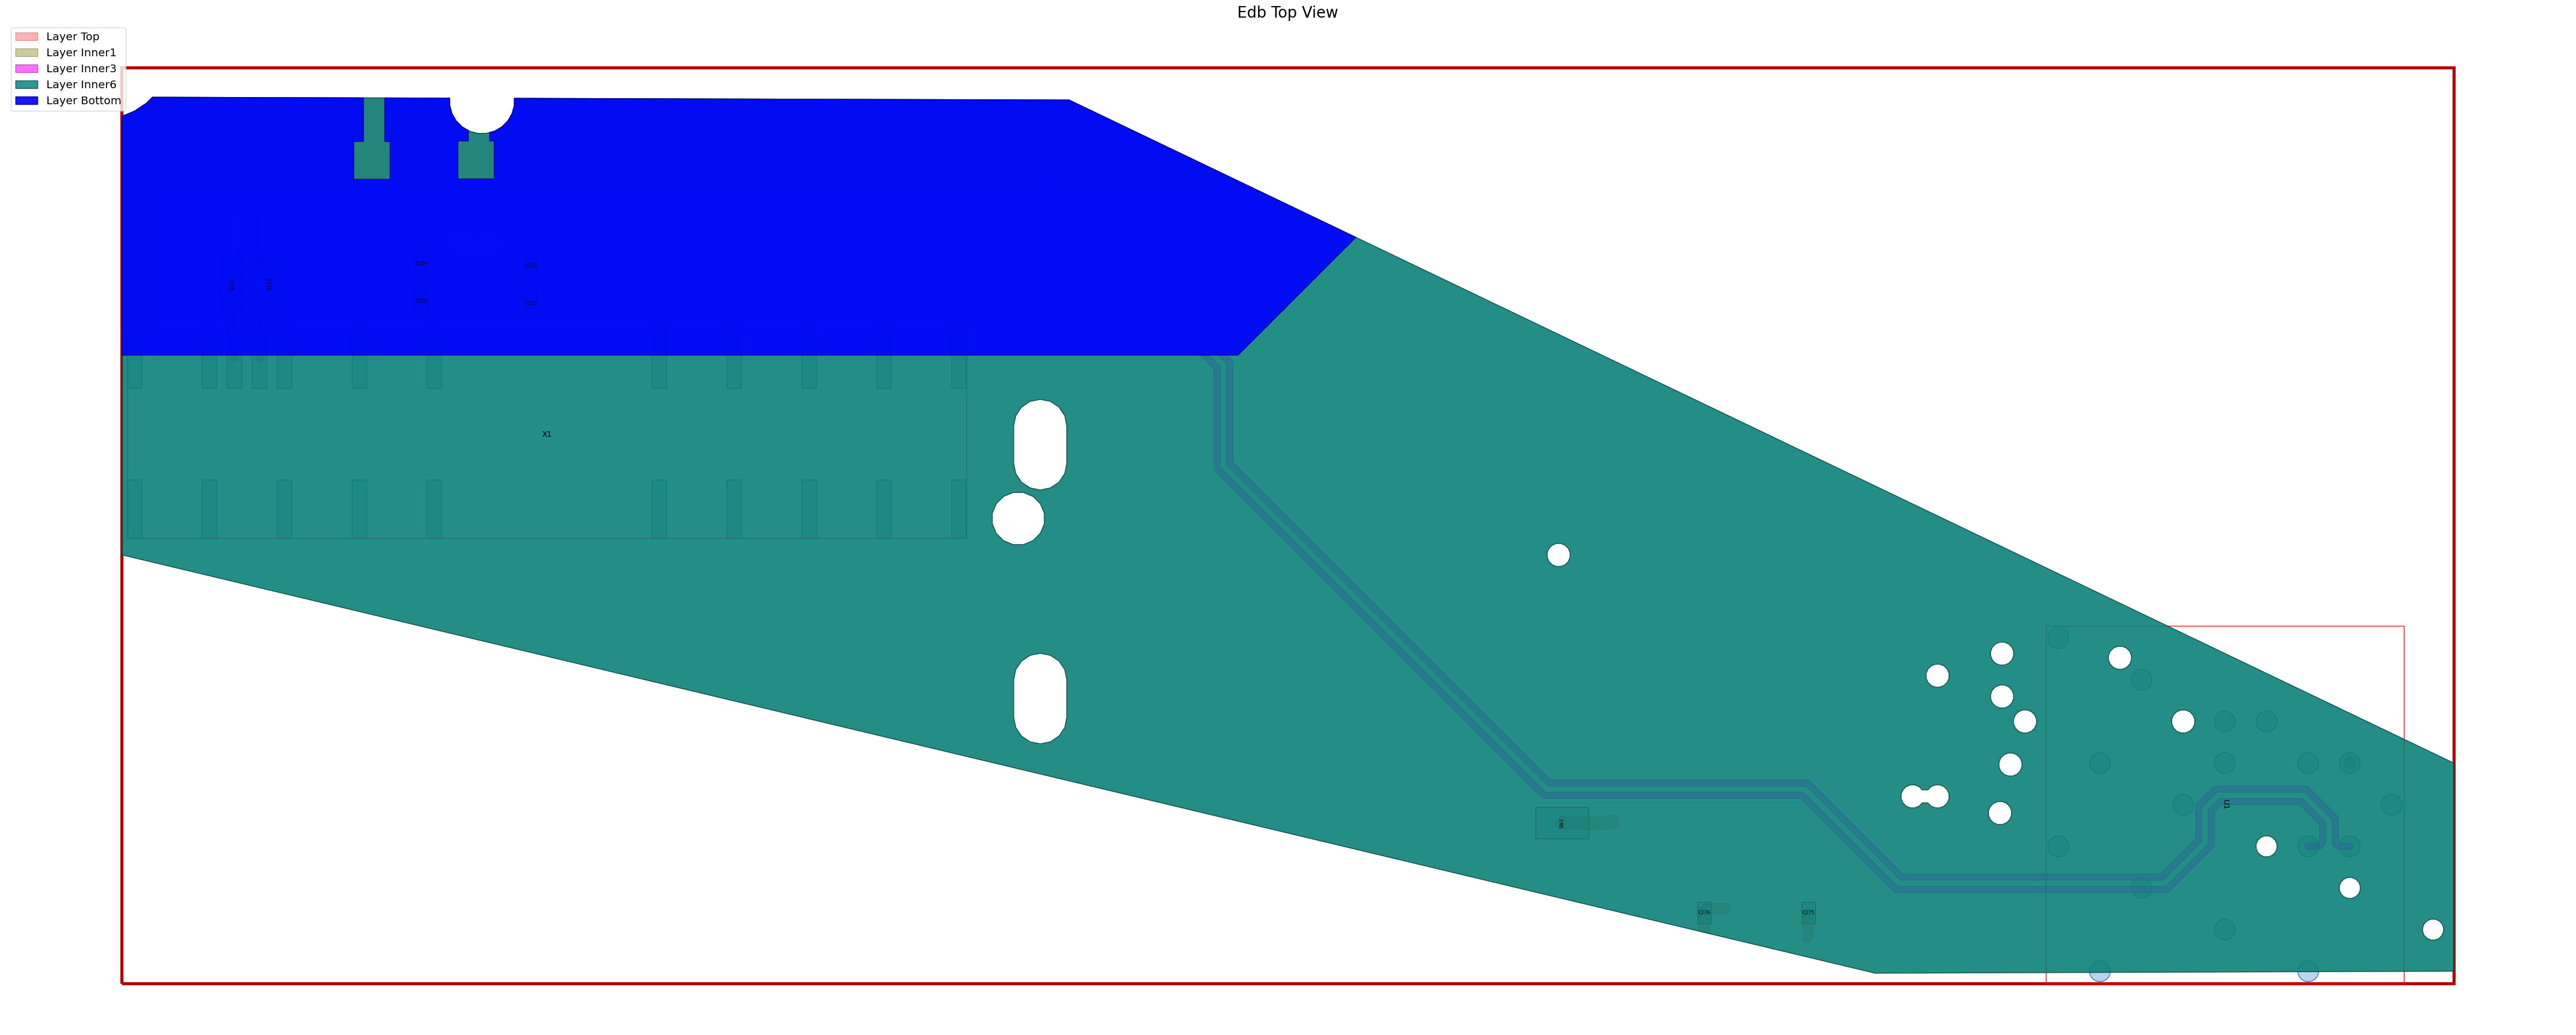

In [16]:
edbapp.nets.plot(nets=[])

Save and close EDB.

In [17]:
edbapp.save()
edbapp.close()

True

The configured EDB file is saved in a temp folder.

In [18]:
print(temp_folder.name)

C:\Users\ansys\AppData\Local\Temp\tmp415zozi8.ansys


## Load edb into HFSS 3D Layout.

In [19]:
h3d = Hfss3dLayout(edbapp.edbpath, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_7e7e93a2-8267-4ab4-8540-cb6b0b880363.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 60414


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 6596.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmp415zozi8.ansys\edb/ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


Create differential pair definition.

In [20]:
h3d.set_differential_pair(
    differential_mode="DIFF_BGA",
    assignment="port_1",
    reference="port_2",
)

True

In [21]:
h3d.set_differential_pair(
    differential_mode="DIFF_CONN",
    assignment="port_3",
    reference="port_4",
)

True

Solve.

In [22]:
h3d.analyze(setup="siwave_setup")

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving design setup siwave_setup


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Design setup siwave_setup solved correctly in 0.0h 0.0m 34.0s


True

Plot insertion loss.

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmp415zozi8.ansys/edb/ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmp415zozi8.ansys/edb/ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03125119209289551


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: EDB loaded.


PyAEDT INFO: Layers loaded.


PyAEDT INFO: Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


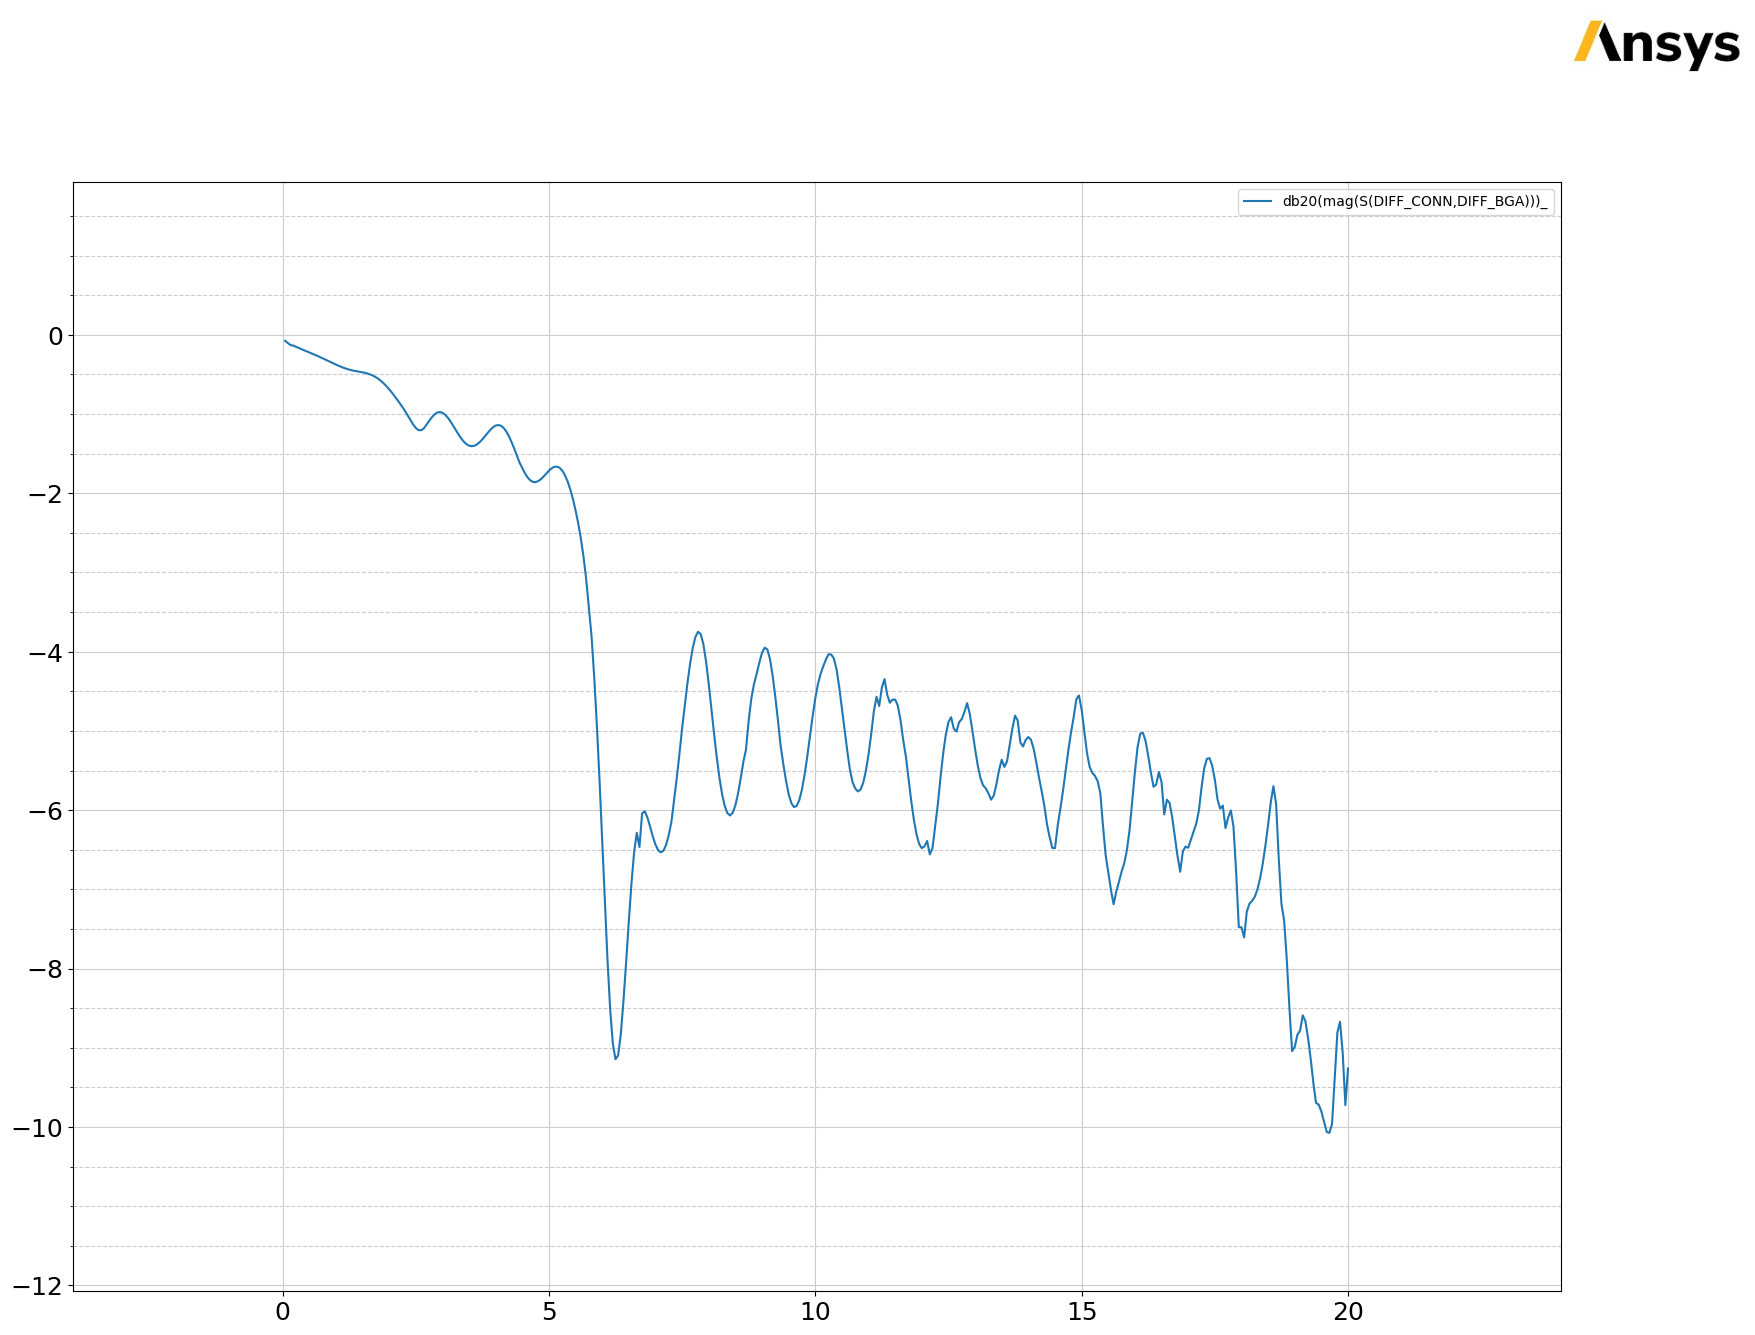

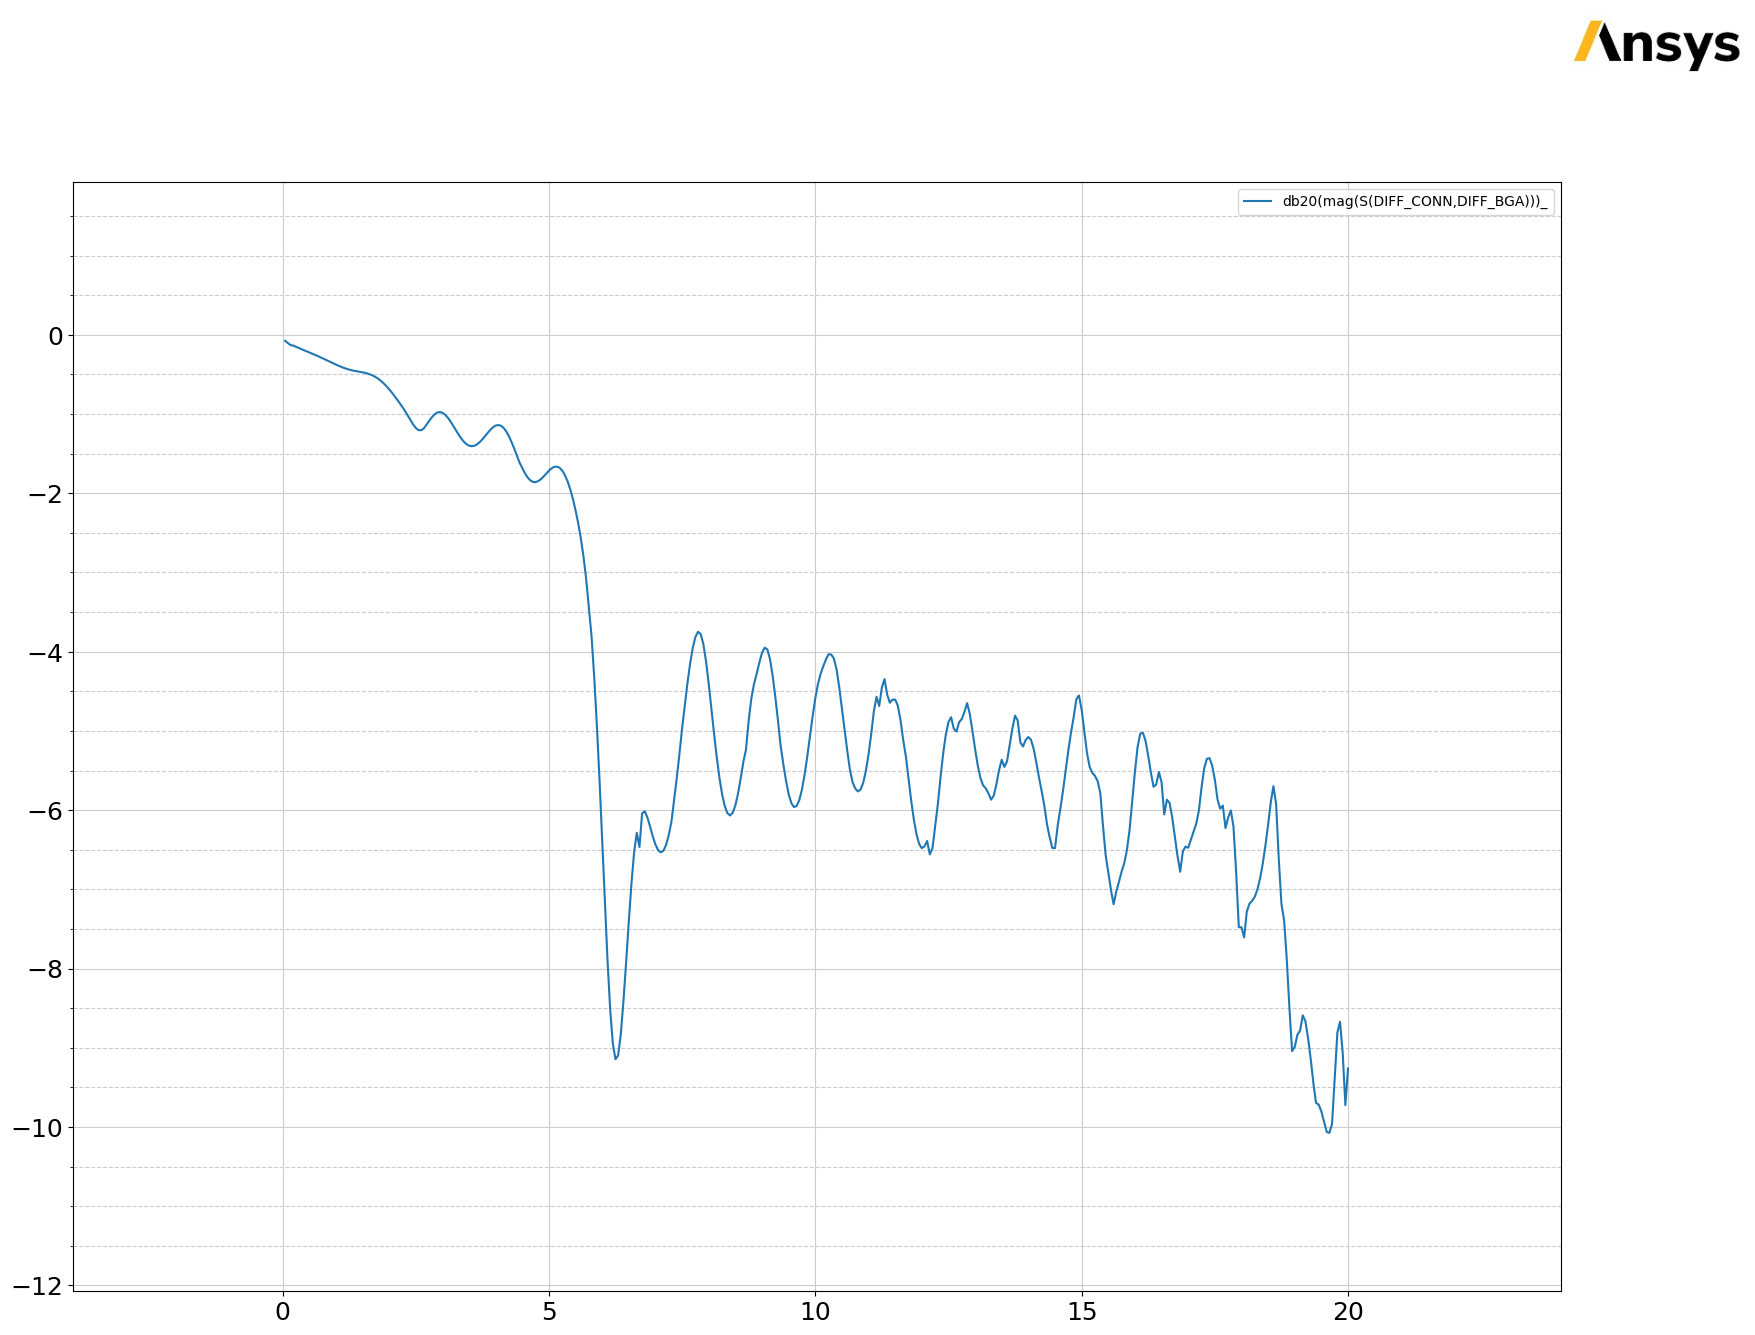

In [23]:
solutions = h3d.post.get_solution_data(expressions="mag(S(DIFF_CONN,DIFF_BGA))", context="Differential Pairs")
solutions.plot(formula="db20")

Shut Down Electronics Desktop

In [24]:
h3d.close_desktop()

PyAEDT INFO: Desktop has been released and closed.


True

All project files are saved in the folder ``temp_file.dir``. If you've run this example as a Jupyter notebook you
can retrieve those project files.